# Classification with stumbleupon data

Project 4 has been changed since scraping was untenable. The project now focuses on the stumbleupon kaggle dataset. For more information on this dataset, [check out the website here](https://www.kaggle.com/c/stumbleupon).

---

## 1. Load in the dataset

This is the only part completed for you.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

%matplotlib inline

In [2]:
su = pd.read_csv('../dataset/evergreen.tsv', delimiter='\t')

## 2. Clean up/examine your data

Some of the columns may have values that need changing or that are of the wrong type. There could also be columns that aren't very useful.

---

In [3]:
## Take a look at the datatypes to get a feel for it and see what column types look incorrect.
su.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                            object
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

In [4]:
## Look at the shape too
su.shape

(7395, 27)

In [5]:
## First look at the news column since it looks to be inproperly encoded in a string.
su.is_news.unique()

## Indeed it looks like the variable for not news is encoded as a '?' rather than a 0.

array(['1', '?'], dtype=object)

In [6]:
## Use the map function to recode the is_news column.
su['is_news'] = su.is_news.map(lambda x: 0 if x == '?' else 1)

In [7]:
## Look at the news_front_page column, which also appears to be incorrectly a string.
su.news_front_page.unique()

array(['0', '?', '1'], dtype=object)

In [8]:
## Replace the '?' in news_front_page with zeros.
def nfp_replace(x):
    if x == '?':
        return float(0)
    else:
        return float(x)
    
su['news_front_page'] = su.news_front_page.map(nfp_replace)

In [10]:
## alchemy_category_score looks to be coded incorrectly as a string.
print su.alchemy_category_score.dtype
print su.alchemy_category_score.unique()

object
['0.789131' '0.574147' '0.996526' ..., '0.14192' '0.196273' '0.617876']


In [11]:
## Convert it to a float, replacing any non-convertable strings with np.nan
## We will return to deal with the nan values later
def alch_cat_score_replace(x):
    try:
        return float(x)
    except:
        return np.nan
    
su['alchemy_category_score'] = su.alchemy_category_score.map(alch_cat_score_replace)

In [12]:
## Let's look at the alchemy_category column.
## There is a '?' and 'unknown' column that can be merged into one, since they mean the same thing.
print su.alchemy_category.unique()

['business' 'recreation' 'health' 'sports' '?' 'arts_entertainment'
 'science_technology' 'gaming' 'culture_politics' 'computer_internet'
 'law_crime' 'religion' 'weather' 'unknown']


In [13]:
## Use map to convert the '?' to 'unknown'
su['alchemy_category'] = su.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

In [14]:
## Look at how many null values for the alchemy_category_score there are by alchemy_category_group
def pct_nulls_by_category(df):
    print df.alchemy_category.unique()[0], sum(df.alchemy_category_score.isnull())/float(len(df.alchemy_category))
    return df
    
tmp = su.groupby('alchemy_category').apply(pct_nulls_by_category)

arts_entertainment 0.0
arts_entertainment 0.0
business 0.0
computer_internet 0.0
culture_politics 0.0
gaming 0.0
health 0.0
law_crime 0.0
recreation 0.0
religion 0.0
science_technology 0.0
sports 0.0
unknown 0.997444633731
weather 0.0


In [15]:
## None of the categories appear to have any nan values except for the 'unknown' category.
## Dropping the data for unknown would be a perfectly reasonable approach. Here I'm instead going
## to fill in values

## I calculate and print out the mean and standard deviation of scores for all of the groups 
## as well as the unknown group.

all_category_mean = su.alchemy_category_score.mean()
all_category_std = su.alchemy_category_score.std()
unknown_category_mean = su[su.alchemy_category == 'unknown'].alchemy_category_score.mean()
unknown_category_std = su[su.alchemy_category == 'u
                          unknown'].alchemy_category_score.std()

print 'All categories score mean: ', all_category_mean
print 'All categories score std: ', all_category_std
print 'Unknown category score mean: ', unknown_category_mean
print 'Unknown category score std: ', unknown_category_std

All categories score mean:  0.603334316624
All categories score std:  0.212863859741
Unknown category score mean:  0.400001
Unknown category score std:  0.0


In [17]:
## I'm going to fill in the unknown scores using a random normal distribution with mean set
## to the mean of the unknown column and standard deviation set to the std of all the categories.
## (I can't use the std of the unknown group since it is zero!)

# Make the mask of the null & unknown rows
mask = (su.alchemy_category_score.isnull()) & (su.alchemy_category == 'unknown')

# Make the new scores according to the distribution I specified.
new_scores = np.random.normal(loc=unknown_category_mean, 
                              scale=all_category_std,
                              size=len(mask))
print new_scores[0:10]

# Put the new scores in using the pandas .ix indexer
su.ix[mask, 'alchemy_category_score'] = new_scores

[ 1.0290363   0.20119939  0.60494715  0.63442704  0.46911681  0.33999662
  0.88912627  0.35328597  0.3327689   0.28229961]


In [18]:
# Check out the new unknown score distribution mean and std:
new_unknown_category_mean = su[su.alchemy_category == 'unknown'].alchemy_category_score.mean()
new_unknown_category_std = su[su.alchemy_category == 'unknown'].alchemy_category_score.std()

print 'Unknown category score mean: ', new_unknown_category_mean
print 'Unknown category score std: ', new_unknown_category_std

Unknown category score mean:  0.393567047818
Unknown category score std:  0.217609926535


In [20]:
# Take a look at the evergreen label to make sure it's just 1s and 0s
su.label.unique()

array([0, 1])

In [21]:
# Calculate the percent positive vs negative classes. It looks pretty even.
print float(su.label.sum()) / len(su.label)

0.513319810683


In [22]:
# Describe all of the columns to see what variables are going to be useful or not 
# and to get a feel for the data in general.

for c in su.columns:
    print c
    print su[c].describe()
    print '\n--------------------------------\n'

url
count                                             7395
unique                                            7395
top       http://www.goaskalice.columbia.edu/1585.html
freq                                                 1
Name: url, dtype: object

--------------------------------

urlid
count     7395.000000
mean      5305.704665
std       3048.384114
min          1.000000
25%       2688.500000
50%       5304.000000
75%       7946.500000
max      10566.000000
Name: urlid, dtype: float64

--------------------------------

boilerplate
count                                                  7395
unique                                                 7394
top       {"title":"Freebase Pancakes NOTCOT ","body":"n...
freq                                                      2
Name: boilerplate, dtype: object

--------------------------------

alchemy_category
count        7395
unique         13
top       unknown
freq         2348
Name: alchemy_category, dtype: object

-----------------------

In [23]:
# drop useless columns. 'framebased', 'url', and 'urlid' don't have useful information for prediction.
pointless_cols = ['framebased', 'url', 'urlid']
su = su.drop(pointless_cols, 1)

In [24]:
# make the target and numeric column labels.
target_col = 'label'
numeric_cols = [x for x in su.select_dtypes(include=[np.number]).columns if x != target_col]

In [111]:
# Check out the head of our su dataset now.
su.head()

,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,...,1,1,24,0.0,5424,170,8,0.152941,0.079130,0
1,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,...,1,1,40,0.0,4973,187,9,0.181818,0.125448,1
2,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,...,1,1,55,0.0,2240,258,11,0.166667,0.057613,1
3,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,...,1,0,24,0.0,2737,120,5,0.041667,0.100858,1
4,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,...,1,1,14,0.0,12032,162,10,0.098765,0.082569,0


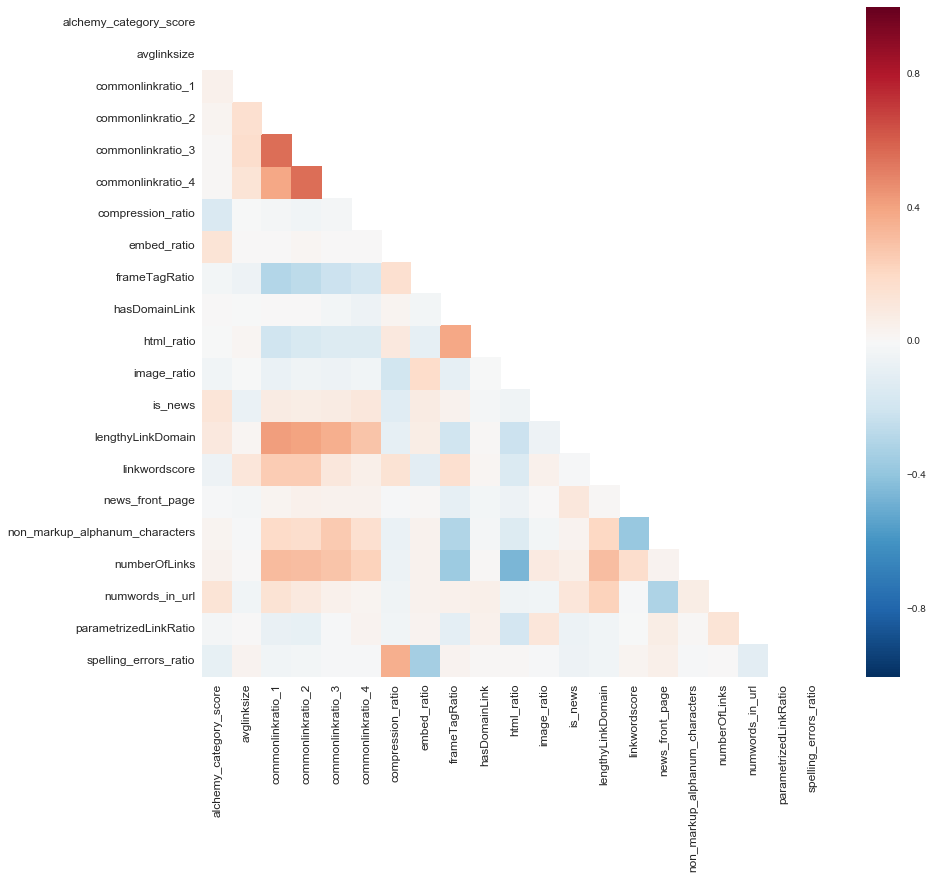

In [25]:
# Get the correlation between numeric columns to look over them with seaborn's heatmap.
su_numeric_corrs = su[numeric_cols].corr()

# I'm going to mask the upper triangle of the correlation matrix to make it nicer in the graph.
# This code below makes the mask.
mask =  np.triu(su_numeric_corrs, k=-1)

# Make a figure and get the axis out, setting the figsize to be decently large.
fig = plt.figure(figsize=(14,12))
ax = fig.gca()

# Make a heatmap of the correlations with the mask and axis
ax = sns.heatmap(su_numeric_corrs, mask=mask, ax=ax)

# Make the label ticks bigger
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()

# The correlation matrix actually looks pretty good.

## 3. Use statsmodels' logistic regression function to look at variable significance

The **`import statsmodels.formula.api as smf`** code below gives us access to a statsmodels api that can run logistic regressions using patsy-style formulas.

Ex:

```python
formula = 'target ~ var1 + var2 + C(var3) -1'
logreg = smf.logit(formula, data=data)
logreg_results = logreg.fit()
print logreg_results.summary()
```

---

In [26]:
import statsmodels.formula.api as smf

### 3.1 Run a logistic regression predicting evergreen from the numeric columns

And print out the results as shown in the example above.

---

In [27]:
formula = 'label ~ ' + ' + '.join(numeric_cols) + ' -1'

eg_lr = smf.logit(formula, data=su)
eg_results = eg_lr.fit()

print eg_results.summary()

Optimization terminated successfully.
         Current function value: 0.651700
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7374
Method:                           MLE   Df Model:                           20
Date:                Wed, 11 May 2016   Pseudo R-squ.:                 0.05931
Time:                        08:26:45   Log-Likelihood:                -4819.3
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                6.690e-116
                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
alchemy_category_score            -0.4289      0.103     -4.153     

### 3.2 Run a logistic regression predicting evergreen from the numeric columns and a categorical variable of alchemy_category

And print out the results as shown in the example.

---

In [28]:
formula_cat = 'label ~ ' + ' + '.join(numeric_cols + ['C(alchemy_category)']) + ' -1'

eg_cat_lr = smf.logit(formula_cat, data=su)
eg_cat_results = eg_cat_lr.fit()

print eg_cat_results.summary()

Optimization terminated successfully.
         Current function value: 0.612121
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7361
Method:                           MLE   Df Model:                           33
Date:                Wed, 11 May 2016   Pseudo R-squ.:                  0.1164
Time:                        08:26:46   Log-Likelihood:                -4526.6
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                1.711e-229
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
C(alchemy_category)[arts_entertainment]     0.544

## 4. Use sklearn to cross-validate the accuracy of the model above

Normalize the numeric and categorical columns of the predictor matrix.

---

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

In [36]:
import patsy

Y, Xcat = patsy.dmatrices(formula_cat, data=su)

print Xcat.shape, Y.shape

Xcat_cols = Xcat.design_info.column_names

Y = np.ravel(Y)

(7395, 34) (7395, 1)


In [42]:
Xcat_n = (Xcat - np.mean(Xcat, axis=0)) / np.std(Xcat, axis=0)

print Xcat_n[0:2]

[[-0.38183904  2.72092063 -0.20419602 -0.2205418  -0.10190158 -0.27101739
  -0.06488196 -0.44645139 -0.09915662 -0.20166769 -0.23274371 -0.68207541
  -0.02326368  1.07060621 -0.08194111  1.02520913 -0.05586734 -0.46892496
  -0.35432928 -0.31755669  0.33847368  0.82887822 -0.1472789   0.22965535
  -0.14163555  0.79029149  0.71724323 -0.29801697 -0.20347634 -0.03296944
  -0.04878443  0.94013354 -0.10870584 -0.27883964]
 [-0.38183904 -0.36752266 -0.20419602 -0.2205418  -0.10190158 -0.27101739
  -0.06488196  2.2398855  -0.09915662 -0.20166769 -0.23274371 -0.68207541
  -0.02326368  0.15811217  0.10629082  0.19589891  0.50902122  1.269555
   1.30980246 -0.31319727  0.33847368  1.02031282 -0.1472789  -0.57711144
  -0.0974664   0.79029149  0.71724323  0.48661515 -0.20347634 -0.0837873
   0.04594734  1.24945404  0.04885672  0.3058009 ]]


In [45]:
logreg = LogisticRegression()

lr_scores = cross_val_score(logreg, Xcat_n, Y, cv=25)
print lr_scores
print np.mean(lr_scores)

[ 0.61148649  0.64864865  0.66554054  0.68243243  0.66216216  0.66891892
  0.64864865  0.70608108  0.65540541  0.63513514  0.61486486  0.64189189
  0.65540541  0.69932432  0.70945946  0.63513514  0.63851351  0.68243243
  0.67567568  0.66216216  0.67567568  0.68474576  0.65423729  0.67118644
  0.69727891]
0.663297936124


## 5. Gridsearch regularization parameters for logistic regression

Find the best regularization type (Ridge, Lasso) across a set of regularization strengths.

[NOTE: C is the inverse of the regularization strength. Lower C values are stronger regularization. Having a C higher than 1 will significantly slow down the search. I'm not particularly interested in values over 1, since this is the default regularization strength in LogisticRegression.]

---

In [63]:
from sklearn.grid_search import GridSearchCV

In [77]:
lr = LogisticRegression()

lr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-4,0,50),
}

lr_gs = GridSearchCV(lr, lr_parameters, cv=10)

lr_gs.fit(Xcat_n, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.45635e-04,   2.12095e-04,   3.08884e-04,
         4.49843e-04,   6.55129e-04,   9.54095e-04,   1.38950e-03,
         2.02359e-03,   2.94705e-03,   4.29193e-03,   6.25055e-03,
         9.10298e-03,   1.32571e-02,   1.93070e-02,   2.8...0e+03,   3.23746e+03,   4.71487e+03,
         6.86649e+03,   1.00000e+04]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [78]:
print lr_gs.best_params_
print lr_gs.best_score_

{'penalty': 'l2', 'C': 1.7575106248547894, 'solver': 'liblinear'}
0.665179175118


In [68]:
lr_lasso = LogisticRegression(C=lr_lassocv.C_[0], penalty='l1', solver='liblinear')

lr_lasso_scores = cross_val_score(lr_lasso, Xcat_n, Y, cv=10)

print lr_lasso_scores
print np.mean(lr_lasso_scores)

[ 0.63648649  0.67972973  0.67162162  0.66351351  0.63783784  0.68918919
  0.64546685  0.67794317  0.67794317  0.67208672]
0.665181827922


## 6. Gridsearch neighbors for kNN

Find the best number of neighbors with your predictors to predict the `label` target variable.

Start by bulding a kNN model with a set number of neighbors, then use gridsearch to run through a series of neighbors.

---

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn = KNeighborsClassifier(n_neighbors=11)

knn_scores = cross_val_score(knn, Xcat_n, Y, cv=25)
print knn_scores
print np.mean(knn_scores)

[ 0.62162162  0.61824324  0.6722973   0.73310811  0.67905405  0.66216216
  0.6722973   0.69932432  0.68243243  0.61148649  0.60810811  0.67905405
  0.64527027  0.6722973   0.67905405  0.66216216  0.61148649  0.69932432
  0.66216216  0.61824324  0.65202703  0.65762712  0.64067797  0.66101695
  0.66666667]
0.658688196671


In [51]:
knn_weighted = KNeighborsClassifier(n_neighbors=11, weights='distance')

knn_weighted_scores = cross_val_score(knn_weighted, Xcat_n, Y, cv=25)
print knn_weighted_scores
print np.mean(knn_weighted_scores)

[ 0.62162162  0.63513514  0.66891892  0.73986486  0.66891892  0.68581081
  0.68243243  0.69932432  0.68243243  0.61486486  0.60810811  0.67567568
  0.64527027  0.6722973   0.68581081  0.65878378  0.61486486  0.70945946
  0.66216216  0.625       0.65540541  0.65762712  0.64745763  0.66779661
  0.68367347]
0.662748679499


In [56]:
knn = KNeighborsClassifier()

parameter_grid = {
    'n_neighbors':[1,3,5,7,11,15,21,31,41,51],
    'weights':['uniform', 'distance']
}

knn_gs = GridSearchCV(knn, parameter_grid, cv=10)

knn_gs.fit(Xcat_n, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 11, 15, 21, 31, 41, 51], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
print knn_gs.best_params_
print knn_gs.best_score_

{'n_neighbors': 21, 'weights': 'distance'}
0.672887085869


## 7. Choose a new target from alchemy_category to predict with logistic regression

**Ideally your category choice will have a small fraction of the total rows, but not TOO small!**

---

### 7.1 Chose your target category, create the Y vector, and check the fraction of instances

---

In [88]:
business = (su.alchemy_category == 'business').astype(int).values
print business[0:10]
print float(np.sum(business))/len(business)

[1 0 0 0 0 0 0 0 0 0]
0.118999323867


### 7.2 Use patsy to create an X matrix of the numeric predictors and all two-way interactions between them

Ex:

```python
import patsy

formula_interactions = '~ (var1 + var2 + var3)**2 -1'
X_interactions = patsy.dmatrix(formula_interactions, data=data
```

Get the column names from the `design_info` property of the patsy X matrix.

---

In [95]:
import patsy

formula_num_inter = '~ (' + ' + '.join(numeric_cols) + ')**2 -1'

Xinter = patsy.dmatrix(formula_num_inter, data=su)
Xinter_cols = Xinter.design_info.column_names

print Xinter.shape

(7395, 231)


### 7.3 Normalize the predictor matrix columns

---

In [98]:
Xinter_n = (Xinter - np.mean(Xinter, axis=0)) / np.std(Xinter, axis=0)

In [ ]:
for i, cn in enumerate(Xinter_cols):
    col = Xinter_n[:, i]
    print cn, np.min(col), np.max(col), len(np.unique(col)), np.std(col)

### 7.4 Gridsearch a logistic regression to predict accuracy on your new target from the interaction predictors

Include Ridge and Lasso.

---

In [105]:
lr_biz = LogisticRegression()

lr_biz_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-4,0,20),
}

lr_biz_gs = GridSearchCV(lr_biz, lr_biz_parameters, cv=5, verbose=1)

lr_biz_gs.fit(Xinter_n, business)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l2, C=0.0001, solver=liblinear -   0.2s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] ..........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  1.9min



[CV] penalty=l1, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l1, C=1.62377673919, solver=liblinear -   5.1s
[CV] penalty=l1, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l1, C=1.62377673919, solver=liblinear -   8.3s
[CV] penalty=l1, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l1, C=1.62377673919, solver=liblinear -   7.6s
[CV] penalty=l1, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l1, C=1.62377673919, solver=liblinear -   8.7s
[CV] penalty=l2, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l2, C=1.62377673919, solver=liblinear -   2.0s
[CV] penalty=l2, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l2, C=1.62377673919, solver=liblinear -   2.2s
[CV] penalty=l2, C=1.62377673919, solver=liblinear ...................
[CV] .......... penalty=l2, C=1.62377673919, solver=liblinear -   2.6s
[CV] 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  9.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.83298e-04,   3.35982e-04,   6.15848e-04,
         1.12884e-03,   2.06914e-03,   3.79269e-03,   6.95193e-03,
         1.27427e-02,   2.33572e-02,   4.28133e-02,   7.84760e-02,
         1.43845e-01,   2.63665e-01,   4.83293e-01,   8.85867e-01,
         1.62378e+00,   2.97635e+00,   5.45559e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [106]:
print lr_biz_gs.best_params_
print lr_biz_gs.best_score_

{'penalty': 'l1', 'C': 0.0001, 'solver': 'liblinear'}
0.881000676133


### 7.5 Build a logistic regression with the optimal parameters, and look at the coefficients

---

In [110]:
lr_biz = LogisticRegression(C=lr_biz_gs.best_params_['C'], penalty='l1', solver='liblinear')

lr_biz.fit(Xinter_n, business)

for cn, coef in zip(Xinter_cols, lr_biz.coef_[0]):
    print cn, coef

alchemy_category_score 0.0
avglinksize 0.0
commonlinkratio_1 0.0
commonlinkratio_2 0.0
commonlinkratio_3 0.0
commonlinkratio_4 0.0
compression_ratio 0.0
embed_ratio 0.0
frameTagRatio 0.0
hasDomainLink 0.0
html_ratio 0.0
image_ratio 0.0
is_news 0.0
lengthyLinkDomain 0.0
linkwordscore 0.0
news_front_page 0.0
non_markup_alphanum_characters 0.0
numberOfLinks 0.0
numwords_in_url 0.0
parametrizedLinkRatio 0.0
spelling_errors_ratio 0.0
alchemy_category_score:avglinksize 0.0
alchemy_category_score:commonlinkratio_1 0.0
alchemy_category_score:commonlinkratio_2 0.0
alchemy_category_score:commonlinkratio_3 0.0
alchemy_category_score:commonlinkratio_4 0.0
alchemy_category_score:compression_ratio 0.0
alchemy_category_score:embed_ratio 0.0
alchemy_category_score:frameTagRatio 0.0
alchemy_category_score:hasDomainLink 0.0
alchemy_category_score:html_ratio 0.0
alchemy_category_score:image_ratio 0.0
alchemy_category_score:is_news 0.0
alchemy_category_score:lengthyLinkDomain 0.0
alchemy_category_score:li

### 7.6 Gridsearch parameters for a logistic regression with the same target and predictors, but score based on precision rather than accuracy

Look at the documentation.

---

In [118]:
lr_biz_pr = LogisticRegression()

lr_biz_pr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-4,0,20)
}

lr_biz_pr_gs = GridSearchCV(lr_biz_pr, lr_biz_pr_parameters, 
                               cv=5, verbose=2, scoring='precision')

lr_biz_pr_gs.fit(Xinter_n, business)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l2, C=0.0001, solver=liblinear -   0.1s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] ..........

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.5s



[CV] penalty=l1, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000695192796178, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000695192796178, solver=liblinear -   0.1s
[CV] penalty=l1, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000695192796178, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000695192796178, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000695192796178, solver=liblinear -   0.0s
[CV] penalty=l2, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l2, C=0.000695192796178, solver=liblinear -   0.3s
[CV] penalty=l2, C=0.000695192796178, solver=liblinear ...............
[CV] ...... penalty=l2, C=0.000695192796178, solver=liblinear -   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:   48.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.62378e-04,   2.63665e-04,   4.28133e-04,
         6.95193e-04,   1.12884e-03,   1.83298e-03,   2.97635e-03,
         4.83293e-03,   7.84760e-03,   1.27427e-02,   2.06914e-02,
         3.35982e-02,   5.45559e-02,   8.85867e-02,   1.43845e-01,
         2.33572e-01,   3.79269e-01,   6.15848e-01,   1.00000e+00]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=2)

In [119]:
print lr_biz_pr_gs.best_params_
print lr_biz_pr_gs.best_score_

{'penalty': 'l2', 'C': 0.00026366508987303583, 'solver': 'liblinear'}
0.157142857143


## [BONUS] 8. Build models predicting from words

This is a bit of the NLP we covered in the pipeline lecture!

---

### 8.1 Choose 'body' or 'title' from the boilerplate to be the basis of your word predictors

You will need to parse the json from the boilerplate field.

---

In [120]:
import json

su['title'] = su.boilerplate.map(lambda x: json.loads(x).get('title', ''))

su['title'].fillna('', inplace=True)

### 8.2 Use CountVectorizer to create your predictor matrix from the string column

It is up to you what range of ngrams and features, and whether or not you want the columns binary or counts.

---

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 5000,
                             ngram_range=(1, 2),
                             stop_words='english',
                             binary=True)

In [124]:
title_X = vectorizer.fit_transform(su.title)
title_cols = vectorizer.get_feature_names()
print len(title_cols)

5000


### 8.3 Gridsearch a logistic regression predicting accuracy of your chosen target category from word predictor matrix

---

In [129]:
lr_biz_titles = LogisticRegression()

lr_biz_titles_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-4,2,60),
}

lr_biz_titles_gs = GridSearchCV(lr_biz_titles, lr_biz_titles_parameters, cv=5, verbose=2)

lr_biz_titles_gs.fit(title_X, business)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l2, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l2, C=0.0001, solver=liblinear ..........................
[CV] .........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    2.0s



[CV] penalty=l2, C=0.00335292414925, solver=liblinear ................
[CV] ....... penalty=l2, C=0.00335292414925, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l1, C=0.0042375871606, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l1, C=0.0042375871606, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l1, C=0.0042375871606, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l1, C=0.0042375871606, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l1, C=0.0042375871606, solver=liblinear -   0.0s
[CV] penalty=l2, C=0.0042375871606, solver=liblinear .................
[CV] ........ penalty=l2, C=0.0042375871606, solver=liblinear -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   23.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.26385e-04,   1.59731e-04,   2.01876e-04,
         2.55141e-04,   3.22459e-04,   4.07539e-04,   5.15068e-04,
         6.50968e-04,   8.22724e-04,   1.03980e-03,   1.31415e-03,
         1.66088e-03,   2.09910e-03,   2.65295e-03,   3.3...1e+01,
         4.95354e+01,   6.26052e+01,   7.91234e+01,   1.00000e+02]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [130]:
print lr_biz_titles_gs.best_params_
print lr_biz_titles_gs.best_score_

{'penalty': 'l2', 'C': 0.36251170499885355, 'solver': 'liblinear'}
0.884516565247


### 8.4 Do the same as above, but score the gridsearch based on precision rather than accuracy

---

In [133]:
lr_biz_titles_pr = LogisticRegression()

lr_biz_titles_pr_parameters = {
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':np.logspace(-4,2,60)
}

lr_biz_titles_pr_gs = GridSearchCV(lr_biz_titles_pr, lr_biz_titles_pr_parameters, 
                                   cv=5, verbose=2, scoring='precision')

lr_biz_titles_pr_gs.fit(title_X, business)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.0001, solver=liblinear ..........................
[CV] ................. penalty=l1, C=0.0001, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.000126384820293, solver=liblinear ...............
[CV] ...... penalty=l1, C=0.000126384820293, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.000126384820293, solver=liblinear ...............
[CV] ...... pen

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    2.0s



[CV] penalty=l1, C=0.179571449437, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.179571449437, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.179571449437, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.179571449437, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.179571449437, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.179571449437, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.179571449437, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.179571449437, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.226951053669, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.226951053669, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.226951053669, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.226951053669, solver=liblinear -   0.0s
[CV] penalty=l1, C=0.226951053669, solver=liblinear ..................
[CV] ......... penalty=l1, C=0.226951053669, solver=liblinear -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    8.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e-04,   1.26385e-04,   1.59731e-04,   2.01876e-04,
         2.55141e-04,   3.22459e-04,   4.07539e-04,   5.15068e-04,
         6.50968e-04,   8.22724e-04,   1.03980e-03,   1.31415e-03,
         1.66088e-03,   2.09910e-03,   2.65295e-03,   3.35292e-...1e+01,
         4.95354e+01,   6.26052e+01,   7.91234e+01,   1.00000e+02]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=2)

In [134]:
print lr_biz_titles_pr_gs.best_params_
print lr_biz_titles_pr_gs.best_score_

{'penalty': 'l1', 'C': 0.11242100350620873, 'solver': 'liblinear'}
0.77


### 8.5 Build a logistic regression with optimal precision categories

Print out the top 20 or 25 word features as ranked by their coefficients.

---

In [138]:
lr_biz_titles_pr = LogisticRegression(penalty='l1', C=lr_biz_titles_pr_gs.best_params_['C'],
                                      solver='liblinear')

lr_biz_titles_pr.fit(title_X, business)

coefs = pd.DataFrame({'coefs':lr_biz_titles_pr.coef_[0],
                      'variable':title_cols})

In [140]:
coefs.sort(columns=['coefs'], ascending=False, inplace=True)

coefs.head(25)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,coefs,variable
3290,1.609655,pasta
851,1.150015,chicken
343,1.118865,baked
3818,0.609905,roasted
1223,0.591546,cream
218,0.501850,allrecipes com
826,0.486255,cheese
1822,0.458393,food
1121,0.407564,cookies
2560,0.370420,kitchen
